In this notebook I use hyperoptimisation to find the best data filters and the best decision tree parameters.

In [1]:
from path import Path
import arrow
import json
import pytz
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
import re, os, collections, itertools, uuid, logging
import tempfile
# import tables

import zipfile
import urllib

import ee
import pyproj
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import shapely


%matplotlib inline
# %precision 4
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6) # bigger plots

In [301]:
from collections import OrderedDict
import tabulate
from IPython.display import Markdown, display

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']="" # don't need this for skleanr

In [3]:
import keras
import tensorflow
import sklearn
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape, InputLayer, Permute, RepeatVector, Dropout, LocallyConnected1D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D
from keras.layers.convolutional import Convolution1D, MaxPooling1D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.layers import (Input, LocallyConnected1D, ZeroPadding1D, Cropping1D, Embedding, Merge, merge,
    Cropping2D, Convolution1D, Convolution2D, Deconvolution2D, BatchNormalization, UpSampling1D, RepeatVector)
from keras.layers import embeddings, convolutional, activations, normalization, advanced_activations, ZeroPadding2D, UpSampling2D
from keras.models import Model
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

Using TensorFlow backend.


In [4]:
# %load_ext autoreload
# %autoreload 2

In [5]:
# %load_ext autoreload
# %autoreload 2

helper_dir = str(Path('.').abspath())
if helper_dir not in os.sys.path:
    os.sys.path.append(helper_dir)
    
from leak_helpers.earth_engine import display_ee, get_boundary, tifs2np, bands_s2, download_image, bands_s2
from leak_helpers.geometry import diffxy, resample_polygon
from leak_helpers.modelling import ImageDataGenerator, dice_coef_loss
from leak_helpers.visualization import imshow_bands
from leak_helpers.analysis import parse_classification_report, find_best_dummy_classification, calculate_result_class
from leak_helpers.modelling.filters import is_not_cloudy, is_not_center_cloudy, is_image_within, is_leak, filter_split_data

In [6]:
keras.__version__, tensorflow.__version__

('1.2.2', '1.0.0')

In [302]:
# params

data_path = [
#         Path('../data/scraped_satellite_images/s2-AUTX_v6_COPERNICUS-S2'),
    Path('../data/scraped_satellite_images/l7-AUTX_v2_LANDSAT-LE7_L1T'),
#     Path('../data/scraped_satellite_images/l8-AUTX_v2_LANDSAT-LC8_L1T'),
#     Path('../data/scraped_satellite_images/s1-all_COPERNICUS-S1_GRD'),   # small
][0]

notebook_name = 'leak_detection_CNN'
batch_size=128
random_seed = 1337
test_fraction = 0.4
timespan_before = 60*60*24*2 # we will only take image that where X seconds before the leak (e.g. 1 day)
max_cloud_cover = 1.1 # cloud cover must less than this
thresh = 0.5 # balance precision vs recall
balanced_classes = False 
normalized = True

# derived
seconds_in_a_day = 60*60*24
ts=arrow.utcnow().format('YYYYMMDD-HH-mm-ss')
model_name = '{notebook_name:}__{ts:}'.format(ts=ts,notebook_name=notebook_name)
outdir = Path('../output').joinpath(model_name)
outdir.makedirs_p()
outdir

target_names = ['no leak','leak']

In [303]:

script_metadata = json.load(open(data_path.joinpath('script_metadata.json')))
# test load
import h5py
metadatas = json.load(open(data_path.joinpath('data_metadata.json')))
with h5py.File(data_path.joinpath('data.h5'),'r') as h5f:
    X_raw = h5f['X'][:]
    y_raw = h5f['y'][:]
X_raw.shape, y_raw, metadatas[0].keys()

((3564, 14, 25, 25),
 array([False, False, False, ..., False, False,  True], dtype=bool),
 dict_keys(['distance', 'name', 'scale', 'leak', 'crs', 'image']))

## Get data

In [304]:
X_train, y_train, metadata_train, X_val, y_val, metadata_val, X_test, y_test, metadata_test = filter_split_data(
    X_raw,
    y_raw,
    metadatas,
    max_cloud_cover=1.1, 
    timespan_before=timespan_before,
    test_fraction=test_fraction, 
    random_seed=random_seed,
    balanced_classes=balanced_classes,
    normalized=normalized,
    filter_center_cloudy=True,
)   
print(X_train.shape,y_train.shape, len(metadata_train))
print(X_test.shape,y_test.shape, len(metadata_test))
print(X_val.shape,y_val.shape, len(metadata_val))

(926, 14, 25, 25) (926,) 926
(883, 14, 25, 25) (883,) 883
(398, 14, 25, 25) (398,) 398


# model

- batch norm helped
- normalising X helped

Refs:
- conv only net uses strides instead of MaxPooling
- example of heatmap generationg https://github.com/heuritech/convnets-keras/blob/master/convnetskeras/convnets.py

In [305]:
# conv model

def get_model(input_shape, batch_norm=True, activation='relu', border_mode='same', channels = 14*2, pooling = 2):    
    
    model = Sequential()
    # batch_input_shape=(None, X_train.shape[1], pixel_length, pixel_length)
    model.add(InputLayer(input_shape=input_shape, name='input'))
    model.add(Permute((2,3,1)))

    model.add(Convolution2D(channels,3,3,border_mode=border_mode,subsample=(pooling, pooling)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Convolution2D(channels*3,3,3,border_mode=border_mode,subsample=(3, 3)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Convolution2D(channels*2*3,3,3,border_mode=border_mode,subsample=(pooling, pooling)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Convolution2D(channels*2*3*2,1,1,border_mode=border_mode,subsample=(pooling, pooling)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(Convolution2D(1,1,1,border_mode=border_mode))
    model.add(Flatten())
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer='nadam', metrics=['accuracy'])
    
    return model

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
# model = get_model(input_shape, border_mode='same' ,batch_norm=True)


# Hyperopt

## hyperopt nn

In [306]:
# hypropt nn
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
import sys
from sklearn.dummy import DummyClassifier

space = {
        
            # model
            'batch_norm': hp.choice('batch_norm', [False, True]),
            'activation':hp.choice('batch_norm', ['relu','tanh','hard_sigmoid','sigmoid']),
            'channels': 14*2,
            'pooling':2,
            'optimizer':'nadam',
    
            # data
            'max_cloud_cover':hp.uniform('max_cloud_cover', 0.01, 0.3),
            'timespan_before': seconds_in_a_day*1, # hp.uniform('timespan_before', seconds_in_a_day*1, seconds_in_a_day*7),
            'balanced_classes':hp.choice('balanced_classes', [False, True]),
            'normalized': hp.choice('normalized', [False, True]),
            'filter_center_cloudy': hp.choice('filter_center_cloudy', [False, True]),
    
            # std is 5% so max should prob be ~5%
            'channel_shift_range': 0.007, #hp.uniform('channel_shift_range', 0.0, 0.07),
            'rotation_range': 25, #hp.uniform('rotation_range', 0.0, 45),
    
            'batch_size' : batch_size,
            'samples_per_epoch': len(X_raw)*4,
            'nb_epochs' :  40,
        }

# from keras.models import Sequential
# from keras.layers import InputLayer
# from keras.layers.core import Dense, Dropout, Activation
# from keras.optimizers import Adadelta, Adam, rmsprop

# TODO make everything run of the params
# TODO encode params into hyperopt
# TODO run some trials to try differen't data types, could use decision tree, or even null model?
def f_nn(params):   

    # Get data
    X_train, y_train, metadata_train, X_val, y_val, metadata_val, X_test, y_test, metadata_test = filter_split_data(
        X_raw,
        y_raw,
        metadatas,
        max_cloud_cover=params['max_cloud_cover'], 
        timespan_before=params['timespan_before'],
        test_fraction=test_fraction, 
        random_seed=random_seed,
        balanced_classes=params['balanced_classes'],
        normalized=params['normalized'],
        filter_center_cloudy=params['filter_center_cloudy']
    )    

    datagen = ImageDataGenerator(
    #     featurewise_center=True,
    #     featurewise_std_normalization=True,
        channel_shift_range=params['channel_shift_range'],
        rotation_range=params['rotation_range'],
    #     width_shift_range=0.05,
    #     height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
       dim_ordering='th',
    #     rescale=0.02,
    #     zoom_range=0.05,
    #     shear_range=0.05,
    )

    # datagen.fit(X_train)

    # Get model
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    model = get_model(
        input_shape, 
        border_mode=params['border_mode'],
        batch_norm=params['batch_norm'],
        channels=params['channels'],
        pooling=params['pooling']
        
    )

    if balanced_classes:
        model.compile(loss='binary_crossentropy',optimizer=params['optimizer'], metrics=['accuracy','matthews_correlation'])
    else:
        model.compile(loss=dice_coef_loss,optimizer=params['optimizer'], metrics=['accuracy','matthews_correlation'])

    # pretrain/test
    history = model.fit_generator(
        datagen.flow(X_train, y_train, batch_size=params['batch_size']),
        samples_per_epoch=params['samples_per_epoch'],
        verbose=0, 
        nb_epoch=params['nb_epoch'], 
        validation_data=[X_val,y_val],
        callbacks=[
              TQDMNotebookCallback(),
                keras.callbacks.EarlyStopping(patience=6, monitor='loss'),
                keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)
        ]
    )

    # results
    last_metrics = [x[-1] for x in history.history.values()]
    last_metrics = dict(zip(history.history.keys(),last_metrics))

    # accuracy X_train
    model.compile(loss='binary_crossentropy',optimizer='nadam', metrics=['accuracy','mean_squared_error','precision','recall','fbeta_score','fmeasure','matthews_correlation'])
    score = model.evaluate(X_val,y_val, batch_size=batch_size, verbose=False)
    metrics = dict(zip(model.metrics_names,score))

    # score on X_val
    y_pred = model.predict(X_val, verbose=False).T[0]
    report = parse_classification_report(sklearn.metrics.classification_report(y_val>thresh,y_pred>thresh,target_names=target_names))
    loss=-metrics['matthews_correlation']
    
    X_train2 = X_train.reshape((-1,14*24*24))
    X_val2 = X_val.reshape((-1,14*24*24))
    
    clf = DummyClassifier(strategy='uniform')
    clf.fit(X_train2,y_train)
    y_pred = clf.predict(X_val2)
    score_dummy = clf.score(X_val2, y_val)
    matthews_corrcoef_dummy = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
    report_dummy = parse_classification_report(sklearn.metrics.classification_report(y_val>thresh,y_pred>thresh,target_names=target_names))
    
    
    
    sys.stdout.flush() 
    return dict(
                # core info
                loss=-loss,
                status=STATUS_OK,
        
                # info
                history=history.history, 
                metrics=dict(
                    last_metrics=last_metrics,
                    report=report.to_dict(),
                    metrics=metrics,
                ),
                dummy_metrics=dict(
                    report_dummy=report_dummy.to_dict(),
                    score_dummy=score_dummy,
                    matthews_corrcoef_dummy=matthews_corrcoef_dummy,
                ),
                
                # data dumps as json
                attachments=dict(
                    model=model.to_json()
                )
               )
            


# trials = Trials()
# best = fmin(f_nn, space, algo=tpe.suggest, max_evals=2, trials=trials, verbose=2)
# print ('best: ')
# print (best)

## hyperopt filter

In [307]:
"""
This experiment will look at differen't way of filtering data
and will use decision trees as quick ways of evaluating data.
Mathews cooeffecient is used as loss since it performs well for unbalanced datasets.
"""

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
from hyperopt.mongoexp import MongoTrials
import sys
from sklearn import tree
from sklearn.dummy import DummyClassifier
import time
seconds_in_a_day = 60*60*24

trials = Trials(exp_key='data_filters_%s'%data_path.basename())
# trials = MongoTrials('mongo://localhost:27017/hyperopt_leaks2/jobs', exp_key='data_filters_v2')



space = {

            'max_cloud_cover': hp.uniform('max_cloud_cover', 0.01, 1.0),
            'timespan_before': hp.uniform('timespan_before', seconds_in_a_day*0.5, seconds_in_a_day*7),
            'balanced_classes':hp.choice('balanced_classes', [False, True]),
            'normalized': hp.choice('normalized', [False, True]),
            'filter_center_cloudy': False, #hp.choice('filter_center_cloudy', [False, True]),
    
            # std is 5% so max should prob be ~5%
            'channel_shift_range': hp.uniform('channel_shift_range', 0.0, 0.25),
            'rotation_range': hp.uniform('rotation_range', 0.0, 45),
            'width_shift_range': hp.uniform('width_shift_range', 0.0, 0.5),
            'height_shift_range': hp.uniform('height_shift_range', 0.0, 0.5),
            'horizontal_flip': True, #hp.choice('horizontal_flip', [False, True]),
            'vertical_flip': True, #hp.choice('vertical_flip', [False, True]),
            'rescale': hp.uniform('rescale', 0.0, 0.5),
            'zoom_range': 0 ,# hp.uniform('zoom_range', 0.0, 0.5),
            'shear_range': 0, # hp.uniform('shear_range', 0.0, 0.5),
    
            'max_depth': 50,
            'batch_size' : 2000*10,
            'nb_epochs' :  1,
        }


def f_dt(params):
    t0 = time.time()

    # Get data
    X_train, y_train, metadata_train, X_val, y_val, metadata_val, X_test, y_test, metadata_test = filter_split_data(
        X_raw,
        y_raw,
        metadatas,
        max_cloud_cover=params['max_cloud_cover'], 
        timespan_before=params['timespan_before'],
        test_fraction=test_fraction,
        val_fraction=test_fraction,
        random_seed=random_seed,
        balanced_classes=params['balanced_classes'],
        normalized=params['normalized'],
        filter_center_cloudy=params['filter_center_cloudy']
    )  

    datagen = ImageDataGenerator(
    #     featurewise_center=True,
    #     featurewise_std_normalization=True,
        channel_shift_range=params['channel_shift_range'],
        rotation_range=params['rotation_range'],
        width_shift_range=params['width_shift_range'],
        height_shift_range=params['height_shift_range'],
        horizontal_flip=params['horizontal_flip'],
        vertical_flip=params['vertical_flip'],
        rescale=params['rescale'],
        zoom_range=params['zoom_range'],
        shear_range=params['shear_range'],
        dim_ordering='th',
    )

    # datagen.fit(X_train)
    
    gen = datagen.flow(X_train, y_train, batch_size=params['batch_size']*params['nb_epochs'])
    X_trainb, y_trainb = next(gen)
    X_train2b = X_trainb.reshape((len(X_trainb),-1))
    X_val2 = X_val.reshape((len(X_val),-1))
    X_test2 = X_test.reshape((len(X_test),-1))
    
    t1=time.time()-t0

    # Get model    
    model = tree.DecisionTreeRegressor(max_depth=params['max_depth'])
    model.fit(X_train2b, y_trainb) 
    y_pred = model.predict(X_val2)
    score = model.score(X_val2, y_val)


    # score on X_val
    report = parse_classification_report(sklearn.metrics.classification_report(y_val>thresh,y_pred>thresh,target_names=target_names))
    matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
    loss=-matthews_corrcoef
    
    # do a dummy score too
    clf = DummyClassifier(strategy='uniform')
    clf.fit(X_train2b,y_trainb)
    y_pred = clf.predict(X_val2)
    score_dummy = clf.score(X_val2, y_val)
    matthews_corrcoef_dummy = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
    report_dummy = parse_classification_report(sklearn.metrics.classification_report(y_val>thresh,y_pred>thresh,target_names=target_names))
    
    
#     sys.stdout.flush()
    print(t1,'loss',loss)
    return dict(loss=-loss,
                status=STATUS_OK,
                run_time=t1,
                metrics=dict(
                    report=report.to_dict(),
                    matthews_corrcoef=matthews_corrcoef,
                ),             
                dummy_metrics=dict(
                    report_dummy=report_dummy.to_dict(),
                    score_dummy=score_dummy,
                    matthews_corrcoef_dummy=matthews_corrcoef_dummy,
                ),
                attachments=dict(                
#                     model=model.__dict__
                )
               )
            


In [ ]:
best = fmin(f_dt, space, algo=tpe.suggest, max_evals=1000, trials=trials, verbose=1)
print ('best: ')
print (best)

1.595038652420044 loss -0.0386642846727
0.7030308246612549 loss 0.0932923927765
1.8368890285491943 loss -0.00368705710051
1.4079639911651611 loss -0.0166153571975
1.2733204364776611 loss 0.0494893096183
1.181145191192627 loss -0.0272881007883
1.0876176357269287 loss -0.0873704056661


/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


1.743326187133789 loss -0.0
1.926445722579956 loss 0.0193785923943
1.1760334968566895 loss 0.0256270290006
1.0056226253509521 loss 0.0151752911359
0.6968693733215332 loss -0.0
1.6277260780334473 loss 0.0313566404476
1.0868237018585205 loss 0.0327399851106
1.5668323040008545 loss -0.0130328376203
1.2413296699523926 loss 0.0866871379433
1.6522138118743896 loss -0.0115787928458
1.666116714477539 loss 0.032069708152
1.478454351425171 loss 0.0554018715248
1.4123950004577637 loss 0.0432574237166
0.8946154117584229 loss -0.0573102276588
1.3224105834960938 loss -0.0328301167799
0.896176815032959 loss 0.0690553296203
1.2526631355285645 loss -0.0116495714929
0.7282388210296631 loss -0.0490225639152
1.40065336227417 loss -0.0580845778331
1.062377691268921 loss -0.0385831356798
1.9305071830749512 loss -0.00965632680232
1.2048382759094238 loss -0.00383326827693
1.3617136478424072 loss 0.0413901492425
0.6661429405212402 loss 0.0660413176414
1.8069255352020264 loss -0.00166692218296
1.310924530029296

In [126]:
len(trials.trials)

564

In [1]:
from bson import json_util
import json
save_path = Path('../output/hyperopt/{}.json'.format(trials._exp_key))
save_path.dirname().makedirs_p()
json.dump(trials.trials,open(save_path,'w'), default=json_util.default)
save_path

NameError: name 'Path' is not defined

In [4]:
# load
trial_data =json.load(open(save_path))
# trial_data =json.load(open(save_path))
len(trial_data)

NameError: name 'save_path' is not defined

In [288]:
# convert to df


def flatten(d, parent_key='', sep='_'):
    """Flatten dicts."""
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            # also flatten lists with one element
            if isinstance(v,list) and len(v)==1:
                v=v[0]
            items.append((new_key, v))
    return dict(items)
# df = pd.DataFrame([flatten(trial) for trial in trials.trials])
df = pd.DataFrame([flatten(trial) for trial in trial_data])
# df

In [3]:
# lets make a table of major results to record
mean_of=50
metric='result_metrics_report_f1-score_leak'
# metric='result_metrics_matthews_corrcoef'
whitelist = [col for col in df.columns if ('misc_vals' in col) or (metric in col)]+[
    'result_dummy_metrics_report_dummy_f1-score_leak',
    'result_dummy_metrics_report_dummy_support_leak',
    
#     'result_metrics_report_f1-score_leak',
#     'result_metrics_matthews_corrcoef'
]
df50=df.sort_values(metric, ascending=False)[:mean_of][whitelist]

# convert to days
df50['misc_vals_timespan_before']=df50['misc_vals_timespan_before']/seconds_in_a_day

# columns
mean=df50.mean()
std=df50.std()
corr=df50.corr()[metric]
units=['bool', 'frac',
       'frac', 'frac',
       'bool', 'frac', 'deg',
       'days', 'frac',
       '','',
       'int']

# make into df
filter_results = pd.DataFrame(collections.OrderedDict(
    mean=mean,
    std=std,
    corr=corr))
filter_results['units']=units
filter_results=filter_results.round(3)

# print
print('top {mean_of:} scores, \n\n- by metric="{metric:}"\n- for key="{key:}"\n- number of trials={n:}\n'.format(
    mean_of=mean_of,
    key=save_path, 
    metric=metric,
    n=len(trials.trials)
))
import tabulate
markdown=tabulate.tabulate(filter_results,tablefmt='pipe',headers=filter_results.columns)
print(markdown)


NameError: name 'df' is not defined

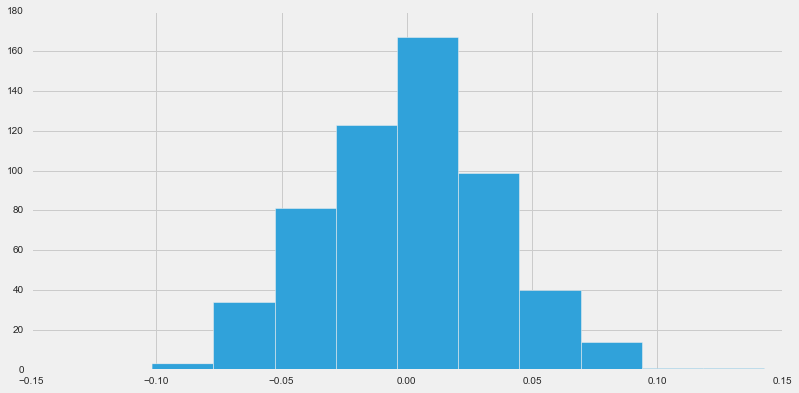

In [143]:
df.result_metrics_matthews_corrcoef.hist()

- don't normalise
- do balance
- shift off 0.005 ish
- cloud cover of less than 0.7 (no effect)
- rotation eange of ~20 deg


Best filters (for f1 values) for dataset:
- l7_joined
    - mean of best 50 f1 values
    
            misc_vals_balanced_classes                                     0.980000
            misc_vals_channel_shift_range                                  0.083127
            misc_vals_height_shift_range                                   0.164816
            misc_vals_max_cloud_cover                                      0.109005
            misc_vals_normalized                                           0.000000
            misc_vals_rescale                                              0.329541
            misc_vals_rotation_range                                       9.903196
            misc_vals_timespan_before                                  97939.315502 (1.13 days)
            misc_vals_width_shift_range                                    0.270787
            result_metrics_report_support_avg / total                    414.480000
            result_metrics_matthews_corrcoef                               0.023856
            result_metrics_report_f1-score_avg / total                     0.418200
            result_metrics_report_f1-score_leak                            0.678600
        
    - Correlations (how important each is)
    
            misc_vals_balanced_classes                      0.623902
            misc_vals_channel_shift_range                  -0.052222
            misc_vals_max_cloud_cover                      -0.021244
            misc_vals_normalized                           -0.196311
            misc_vals_rotation_range                       -0.113902
            misc_vals_timespan_before                       0.084534


In [299]:
filters = ['misc_vals_','result_metrics_','result_dummy_metrics_report_dummy_f1-score_leak','result_run_time']
cols = [col for col in df.columns if any([f in col for f in filters])]
df1 = df[cols]
# df1

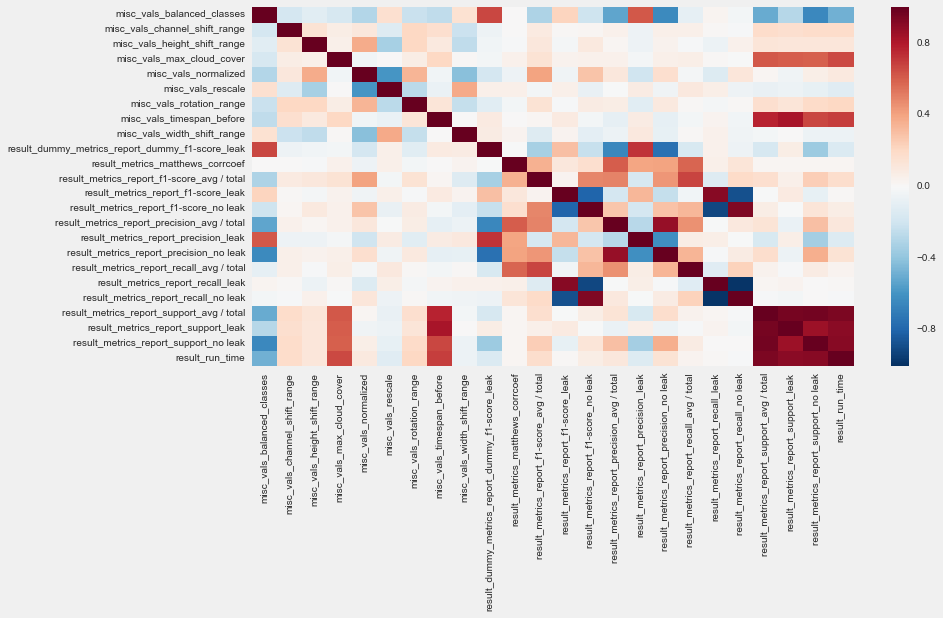

In [300]:
# heat map of correlations
import seaborn as sns
corr = df1.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
# plt.title('')
# plt.savefig('/tmp/cryptocorr.png')

# rotation range etc

**Open the plot below in a new window**

We see rotation range above 25 tends to lose predictive power with 20 being ideal

Cloud cover restrictions seem to do it below 0.6... but I scraped that data to be below 0.3?

Channel shifts>0.01 seems to lose predictive power

In [33]:
df1.columns

Index(['misc_vals_balanced_classes', 'misc_vals_channel_shift_range',
       'misc_vals_max_cloud_cover', 'misc_vals_normalized',
       'misc_vals_rotation_range', 'misc_vals_timespan_before',
       'misc_vals_filter_center_cloudy',
       'result_dummy_metrics_matthews_corrcoef_dummy', 'result_loss',
       'result_metrics_matthews_corrcoef',
       'result_metrics_report_f1-score_leak',
       'result_metrics_report_precision_leak',
       'result_metrics_report_precision_no leak',
       'result_metrics_report_recall_avg / total',
       'result_metrics_report_recall_leak',
       'result_metrics_report_recall_no leak',
       'result_metrics_report_support_avg / total', 'result_run_time'],
      dtype='object')

ValueError: max must be larger than min in range parameter.

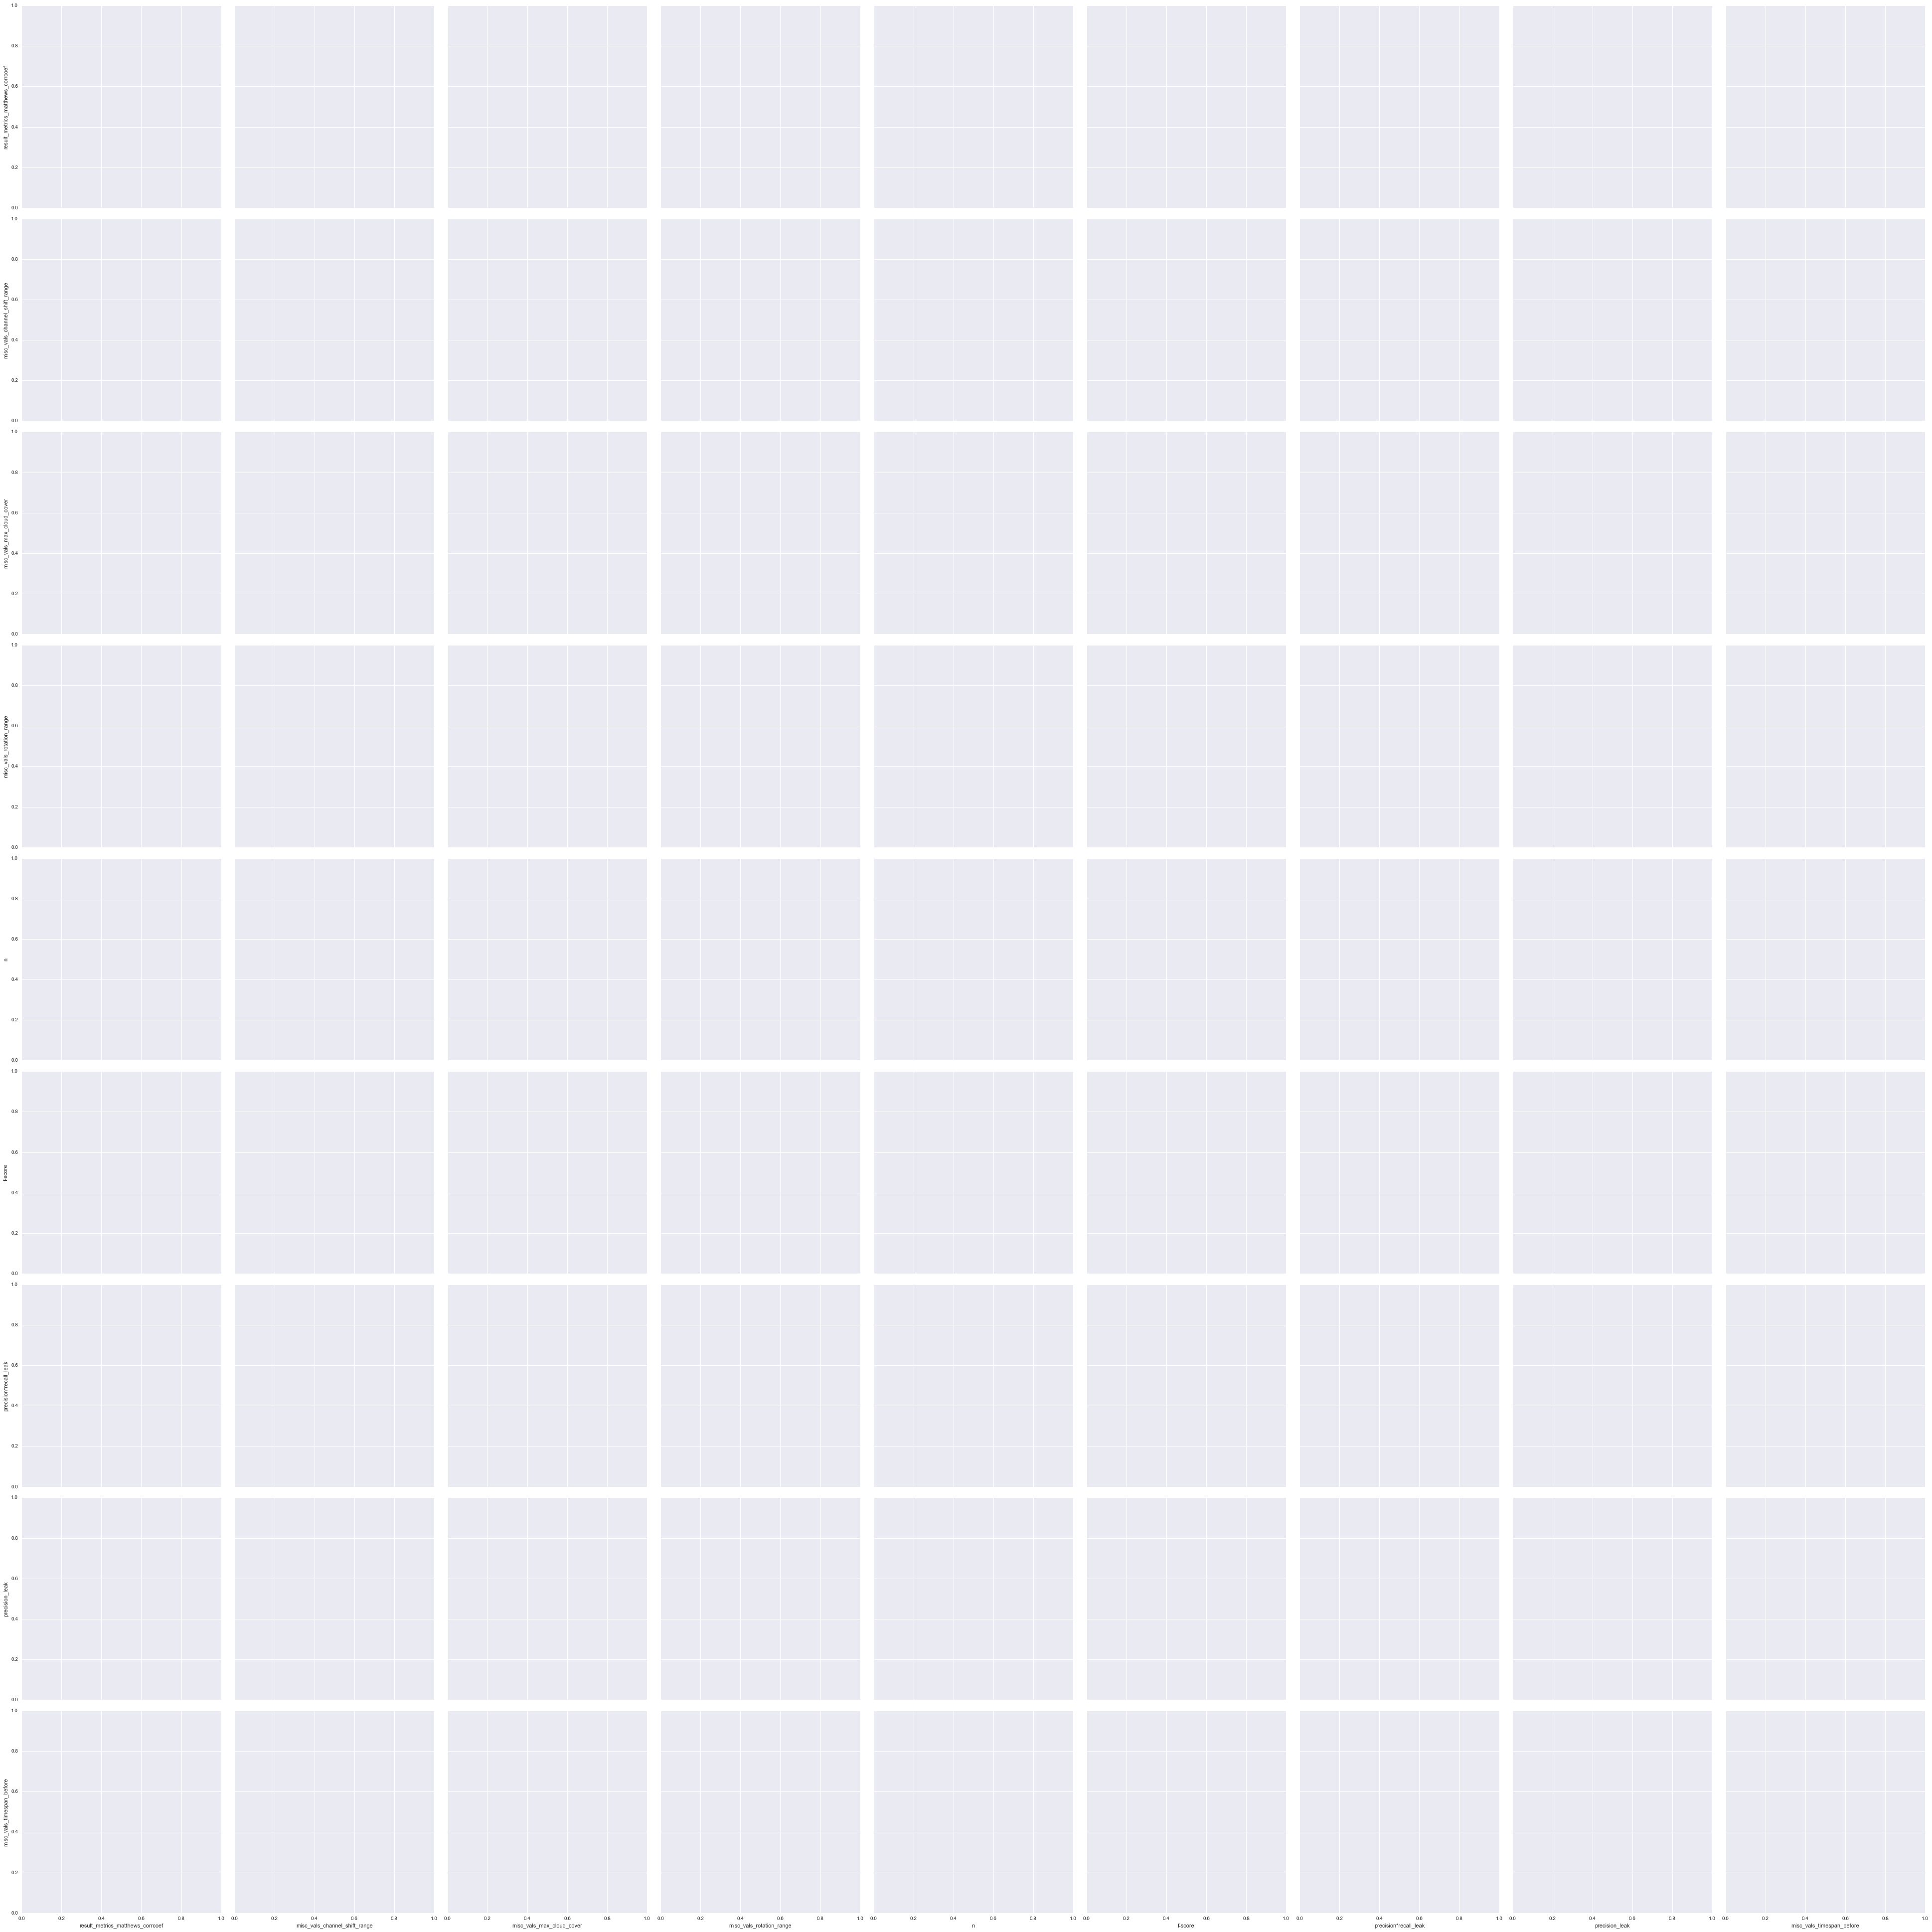

In [37]:
# this show the relationship between predictive power and days before
# so to get a good correlation we want 
sns.set()
plt.figure(figsize=(15,15))
df5=df[[
    'result_metrics_matthews_corrcoef',
    'misc_vals_channel_shift_range',
       'misc_vals_max_cloud_cover',        'misc_vals_rotation_range'
]].copy()
df5['n']=df['result_metrics_report_support_avg / total']
df5['f-score']=df1['result_metrics_report_f1-score_leak']
df5['precision*recall_leak']=df['result_metrics_report_recall_leak']*df['result_metrics_report_precision_leak']
df5['precision_leak']=df['result_metrics_report_precision_leak']
df5['misc_vals_timespan_before']=df.misc_vals_timespan_before/seconds_in_a_day
sns.pairplot(df5,size=6)

# How many days before?

This show how many days before we can go before we lose predictive power (either good or bad)

If you look at the top right graph, we lose predictive power at greater than 5 days. Before that its
exponential increase but I also get a drop of in data. 

So: 2 days looks like the sweet spot.

In [ ]:
# this show the relationship between predictive power and days before
# so to get a good correlation we want 
sns.set()
plt.figure(figsize=(15,15))
df5=df[[
    'result_metrics_matthews_corrcoef'
]].copy()
df5['n']=df['result_metrics_report_support_avg / total']
df5['misc_vals_timespan_before']=df.misc_vals_timespan_before/seconds_in_a_day
sns.pairplot(df5,size=6)

# Hyperopt for randomforest

In [35]:
"""
This experiment will look at the best random forest params
"""

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
import sys
from sklearn.dummy import DummyClassifier
import sklearn.ensemble
import time
seconds_in_a_day = 60*60*24

trials2 = Trials(exp_key='data_filters_v3_rf_ATX')
# trials = MongoTrials('mongo://localhost:27017/hyperopt_leaks2/jobs', exp_key='data_filters_v2')

def hp_int(label,min,max):
    return hp.choice(label, np.arange(min, max, dtype=int)) 


space = {



            # rf
            'n_estimators': hp_int('n_estimators',2,300),
            'criterion': hp.choice('criterion',['gini','entropy']),
            'max_features': hp_int('max_features',2,300),
            'max_depth': hp_int('max_depth',2,300),
            'min_samples_split': hp_int('min_samples_split',1,10),
            'min_samples_leaf': hp_int('min_samples_leaf',1,10),
            'bootstrap':hp.choice('bootstrap',[False,True]),
    
    
            'min_weight_fraction_leaf': 0, # hp.float('min_weight_fraction_leaf',2,10),
            'max_leaf_nodes': None, # hp.int('max_leaf_nodes',2,300),
            'min_impurity_split': 1e-7, #hp.float('min_impurity_split',1e-12,1e-3),
            
            'oob_score': False, # hp.choice('oob_score',[False,True]),
            'n_jobs':4,
            'random_state':0,
            'verbose':0,
            'warm_start':False,
            'class_weight':None,
        
    
            # data filter
            'max_cloud_cover': 0.3,
            'timespan_before': seconds_in_a_day*3,
            'balanced_classes':True,
            'normalized': False,
            'filter_center_cloudy': True,
    
            # std is 5% so max should prob be ~5%
            'channel_shift_range': 0.07,
            'rotation_range': 25,
    
            'max_depth': 50,
            'batch_size' : 2000*10,
            'nb_epochs' :  1,
        }


def f_rf(params):
    t0 = time.time()

    # Get data
    X_train, y_train, metadata_train, X_val, y_val, metadata_val, X_test, y_test, metadata_test = filter_split_data(
        X_raw,
        y_raw,
        metadatas,
        max_cloud_cover=params['max_cloud_cover'], 
        timespan_before=params['timespan_before'],
        test_fraction=test_fraction, 
        random_seed=random_seed,
        balanced_classes=params['balanced_classes'],
        normalized=params['normalized'],
        filter_center_cloudy=params['filter_center_cloudy']
    )   

    datagen = ImageDataGenerator(
    #     featurewise_center=True,
    #     featurewise_std_normalization=True,
        channel_shift_range=params['channel_shift_range'],
        rotation_range=params['rotation_range'],
    #     width_shift_range=0.05,
    #     height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
       dim_ordering='th',
    #     rescale=0.02,
    #     zoom_range=0.05,
    #     shear_range=0.05,
    )

    # datagen.fit(X_train)
    
    gen = datagen.flow(X_train, y_train, batch_size=params['batch_size']*params['nb_epochs'])
    X_trainb, y_trainb = next(gen)
    X_train2b = X_trainb.reshape((-1,14*25*25))
    X_val2 = X_val.reshape((-1,14*25*25))
    X_test2 = X_test.reshape((-1,14*25*25))
    
    t1=time.time()-t0

    # Get model    
    model = sklearn.ensemble.RandomForestClassifier(
        n_estimators=params['n_estimators'],
        criterion=params['criterion'],
        max_features=params['max_features'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'], 
        min_samples_leaf=params['min_samples_leaf'],
        max_leaf_nodes=params['max_leaf_nodes'],
        min_impurity_split=params['min_impurity_split'],
        bootstrap=params['bootstrap'],
        oob_score=params['oob_score'],
        n_jobs=params['n_jobs'],
#         random_state=params['random_state'],
        verbose=params['verbose'],
        warm_start=params['warm_start'],
        class_weight=params['class_weight'],
        
    )
    model.fit(X_train2b, y_trainb) 
    y_pred = model.predict(X_val2)
    score = model.score(X_val2, y_val)

    # score on X_val
    report = parse_classification_report(sklearn.metrics.classification_report(y_val>thresh,y_pred>thresh,target_names=target_names))
    matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
    loss=-matthews_corrcoef
    
#     sys.stdout.flush()
    print(t1,'loss',loss)
    return dict(loss=loss,
                status=STATUS_OK,
                run_time=t1,
                metrics=dict(
                    report=report.to_dict(),
                    matthews_corrcoef=matthews_corrcoef,
                ),             
                attachments=dict(                
#                     model=model.__dict__
                )
               )
            


In [48]:
best = fmin(f_rf, space, algo=tpe.suggest, max_evals=1000, trials=trials2, verbose=1)
print ('best: ')
print (best)

2.272477149963379 loss -0.0831334234745
2.0736782550811768 loss -0.0924210974528
2.413914918899536 loss -0.078942762829
2.1177151203155518 loss -0.152185012789
2.129666805267334 loss -0.0765051303491
2.2079720497131348 loss -0.0576978278033
2.241548776626587 loss -0.0908495972473
2.179779052734375 loss -0.103385151515
2.162714958190918 loss -0.11771247078
2.3401927947998047 loss -0.0884890730573
2.8878297805786133 loss -0.0783214847039
2.1903300285339355 loss -0.0522391331706
2.349170446395874 loss -0.0539767866521
2.5587830543518066 loss -0.106040281861
2.3124563694000244 loss -0.0747560013207
2.6566598415374756 loss -0.092875417357
2.196125030517578 loss -0.0610194766288
2.644954204559326 loss -0.13901848785
2.333570718765259 loss -0.0455991092667
2.249497652053833 loss -0.0759148602085
2.262049436569214 loss -0.065980782972
2.004255533218384 loss -0.10676754388
2.469154119491577 loss -0.00437870597846
2.393832206726074 loss -0.081317742885
2.2206265926361084 loss -0.0785766360178
2.

In [ ]:
trials._exp_key=str(data_path.basename())
len(trials.trials), len(trials2.trials)

In [ ]:
from bson import json_util
import json
save_path = Path('../output/hyperopt/{}.json'.format(trials._exp_key))
save_path.dirname().makedirs_p()
json.dump(trials.trials,open(save_path,'w'), default=json_util.default)
save_path

In [50]:
import collections

def flatten(d, parent_key='', sep='_'):
    """Flatten dicts."""
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            # also flatten lists with one element
            if isinstance(v,list) and len(v)==1:
                v=v[0]
            items.append((new_key, v))
    return dict(items)
df = pd.DataFrame([flatten(trial) for trial in trials2.trials])
# df = pd.DataFrame([flatten(trial) for trial in trial_data])
# df

In [51]:
# df.sort_values('result_metrics_matthews_corrcoef')

In [52]:
df2=df[[
#     'book_time',
#  'exp_key',
#  'misc_cmd',
#  'misc_idxs_bootstrap',
#  'misc_idxs_criterion',
#  'misc_idxs_max_features',
#  'misc_idxs_min_samples_leaf',
#  'misc_idxs_min_samples_split',
#  'misc_idxs_n_estimators',
#  'misc_tid',
 'misc_vals_bootstrap',
 'misc_vals_criterion',
 'misc_vals_max_features',
 'misc_vals_min_samples_leaf',
 'misc_vals_min_samples_split',
 'misc_vals_n_estimators',
#  'misc_workdir',
#  'owner',
#  'refresh_time',
#  'result_loss',
 'result_metrics_matthews_corrcoef',
#  'result_metrics_report_f1-score_avg / total',
 'result_metrics_report_f1-score_leak',
#  'result_metrics_report_f1-score_no leak',
#  'result_metrics_report_precision_avg / total',
 'result_metrics_report_precision_leak',
#  'result_metrics_report_precision_no leak',
#  'result_metrics_report_recall_avg / total',
 'result_metrics_report_recall_leak',
#  'result_metrics_report_recall_no leak',
#  'result_metrics_report_support_avg / total',
#  'result_metrics_report_support_leak',
#  'result_metrics_report_support_no leak',
#  'result_run_time',
#  'result_status',
#  'spec',
#  'state',
#  'tid',
#  'version'
   ]].sort_values('result_metrics_matthews_corrcoef',ascending=False)

- critenrion = 'entropy'
- max_features ~ 100-260
- min_samples_leaf=5
- min_samples_split=5?
- n_estimators=~160
- boostrap, yues?


In [53]:
df2

,misc_vals_bootstrap,misc_vals_criterion,misc_vals_max_features,misc_vals_min_samples_leaf,misc_vals_min_samples_split,misc_vals_n_estimators,result_metrics_matthews_corrcoef,result_metrics_report_f1-score_leak,result_metrics_report_precision_leak,result_metrics_report_recall_leak
482,1,1,52,6,3,274,0.184599,0.60,0.62,0.59
708,0,1,153,7,6,96,0.184059,0.60,0.62,0.59
984,0,1,170,5,6,74,0.184059,0.60,0.62,0.59
230,0,1,140,6,6,132,0.182557,0.59,0.62,0.56
635,1,1,89,7,6,127,0.180301,0.62,0.61,0.63
1,0,1,22,6,1,208,0.179479,0.59,0.62,0.55
369,0,1,142,5,0,207,0.177196,0.58,0.63,0.53
981,1,1,113,7,6,208,0.176973,0.59,0.62,0.57
783,1,1,45,6,7,297,0.176490,0.58,0.63,0.54
318,1,1,248,7,3,99,0.175259,0.60,0.62,0.58


In [55]:
df2[:50].mean()

misc_vals_bootstrap                       0.540000
misc_vals_criterion                       0.980000
misc_vals_max_features                  102.040000
misc_vals_min_samples_leaf                5.840000
misc_vals_min_samples_split               4.380000
misc_vals_n_estimators                  160.840000
result_metrics_matthews_corrcoef          0.157871
result_metrics_report_f1-score_leak       0.584600
result_metrics_report_precision_leak      0.609400
result_metrics_report_recall_leak         0.564200
dtype: float64

In [5]:
df.iloc[482]

NameError: name 'df' is not defined